In [0]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
import warnings
from math import sin, cos, sqrt, atan2, radians,asin
import sys 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
#import xgboost as xgb
from sklearn.metrics import roc_auc_score
#import xgboost as xgb
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
warnings.filterwarnings('ignore')
import pickle
from sklearn.externals import joblib

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_path = 'content/gdrive/My Drive/Colab Notebooks'

In [0]:
from google.colab import files
files.upload() 

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pradeepramaraj","key":"8eaf1cbb1eb37c4de173153c7b593822"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission


kaggle.json


In [0]:
test=pd.read_csv("/content/gdrive/My Drive/test.csv")
print("Shape of Testing Data", test.shape)

Shape of Testing Data (9914, 7)


In [0]:
train=pd.read_csv("gdrive/My Drive/train.csv",nrows=1000000)
print("Shape of Training Data",train.shape)
test=pd.read_csv("gdrive/My Drive/test.csv")
print("/content/gdrive/My Drive/Shape of Testing Data", test.shape)


Shape of Training Data (1000000, 8)
/content/gdrive/My Drive/Shape of Testing Data (9914, 7)


In [0]:
test=pd.read_csv("gdrive/My Drive/test.csv")
print(test.head(10))

                           key          pickup_datetime  pickup_longitude  \
0  2015-01-27 13:08:24.0000002  2015-01-27 13:08:24 UTC        -73.973320   
1  2015-01-27 13:08:24.0000003  2015-01-27 13:08:24 UTC        -73.986862   
2  2011-10-08 11:53:44.0000002  2011-10-08 11:53:44 UTC        -73.982524   
3  2012-12-01 21:12:12.0000002  2012-12-01 21:12:12 UTC        -73.981160   
4  2012-12-01 21:12:12.0000003  2012-12-01 21:12:12 UTC        -73.966046   
5  2012-12-01 21:12:12.0000005  2012-12-01 21:12:12 UTC        -73.960983   
6  2011-10-06 12:10:20.0000001  2011-10-06 12:10:20 UTC        -73.949013   
7  2011-10-06 12:10:20.0000003  2011-10-06 12:10:20 UTC        -73.777282   
8  2011-10-06 12:10:20.0000002  2011-10-06 12:10:20 UTC        -74.014099   
9  2014-02-18 15:22:20.0000002  2014-02-18 15:22:20 UTC        -73.969582   

   pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0        40.763805         -73.981430         40.743835                1  
1 

In [0]:
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]
def clean_data(data):
    boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}
    
    data['pickup_datetime']=pd.to_datetime(data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
    data['pickup_day']=data['pickup_datetime'].apply(lambda x:x.day)
    data['pickup_hour']=data['pickup_datetime'].apply(lambda x:x.hour)
    data['pickup_day_of_week']=data['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
    data['pickup_month']=data['pickup_datetime'].apply(lambda x:x.month)
    data['pickup_year']=data['pickup_datetime'].apply(lambda x:x.year)
    if 'fare_amount' in data.columns:
        data=data[data['fare_amount']>=0]
        data.loc[~((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
        data.loc[((data.pickup_longitude >= boundary['min_lng'] ) & (data.pickup_longitude <= boundary['max_lng']) &
            (data.pickup_latitude >= boundary['min_lat']) & (data.pickup_latitude <= boundary['max_lat']) &
            (data.dropoff_longitude >= boundary['min_lng']) & (data.dropoff_longitude <= boundary['max_lng']) &
            (data.dropoff_latitude >=boundary['min_lat']) & (data.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

    #print("Outlier vs Non Outlier Counts")
    #print(data['is_outlier_loc'].value_counts())

    # Let us drop rows, where location is outlier
        data=data.loc[data['is_outlier_loc']==0]
        data.drop(['is_outlier_loc'],axis=1,inplace=True)
    
    data=data[data['passenger_count']<=8]
    data['pickup_day_of_week']=data['pickup_day_of_week'].apply(lambda x:encodeDays(x))
    return data

In [0]:
train=clean_data(train)
test=clean_data(test)
print("Shape of Training Data after cleaning ",train.shape)
print("Shape of Testing Data after cleaning", test.shape)
train.head()

Shape of Training Data after cleaning  (978799, 13)
Shape of Testing Data after cleaning (9914, 12)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,15,17,1,6,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,5,16,2,1,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,18,0,4,8,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,21,4,6,4,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,9,7,2,3,2010


In [0]:
def processDataForModelling(data,target,drop_cols,is_train=True,split=0.25):
    data_1=data.drop(drop_cols,axis=1)
    # One hot Encoding
    data_1=pd.get_dummies(data_1)
    if is_train==True:
        X=data_1.drop([target],axis=1)
        y=data_1[target]
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=split,random_state=123)
        
        print("Shape of Training Features",X_train.shape)
        print("Shape of Validation Features ",X_test.shape)
        
        return X_train, X_test, y_train, y_test
    else:
        print ("Shape of Test Data",data_1.shape)
        return data_1
    
    
    

In [0]:
X_train, X_test, y_train, y_test=processDataForModelling(train,'fare_amount',drop_cols=['key','pickup_datetime'],is_train=True,split=0.2)

Shape of Training Features (783039, 10)
Shape of Validation Features  (195760, 10)


In [0]:
test_data=processDataForModelling(test,'fare_amount',drop_cols=['key','pickup_datetime'],is_train=False)

Shape of Test Data (9914, 10)


In [0]:
avg_fare=round(np.mean(y_train),2)
avg_fare

11.32

In [0]:
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))
print("Basline RMSE of Validation data :",baseline_rmse)

Basline RMSE of Validation data : 9.659505711183623


In [0]:
y_test.head()

755709    32.1
248836     6.5
829574    14.9
332657     9.5
940304    11.0
Name: fare_amount, dtype: float64

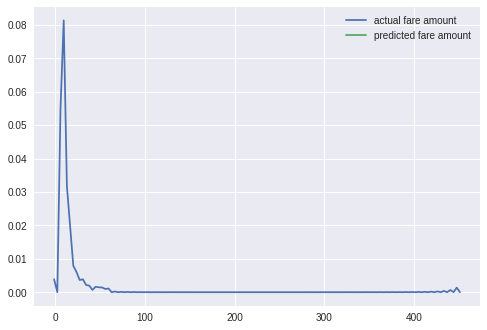

In [0]:
sns.kdeplot(y_test,label='actual fare amount')
sns.kdeplot(baseline_pred,label='predicted fare amount')

##### Build a Linear Regression Model 

In [0]:
lm = LinearRegression()
lm.fit(X_train,y_train)
X_test.head()


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
755709,-73.980303,40.742571,-74.012098,40.612974,1,9,23,5,9,2011
248836,-73.988173,40.734710,-74.000857,40.729682,1,26,14,6,11,2011
829574,-73.992230,40.719905,-73.988146,40.756420,1,1,3,0,11,2009
332657,-73.978058,40.752331,-73.987442,40.768589,1,9,21,4,4,2015
940304,-73.991594,40.749893,-73.973093,40.758296,1,10,8,3,10,2012


In [0]:
pickle.dump(lm, open("gdrive/My Drive/LR.sav", 'wb'))

In [0]:
lm=pickle.load(open('gdrive/My Drive/LR.sav', 'rb'))

In [0]:
y_pred=np.round(lm.predict(X_test),2)


lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  8.219077313138138


In [0]:
y_test.head()

755709    32.1
248836     6.5
829574    14.9
332657     9.5
940304    11.0
Name: fare_amount, dtype: float64

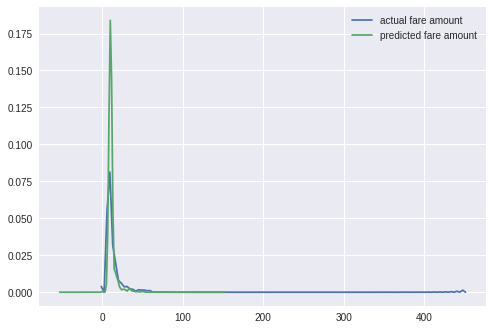

In [0]:
sns.kdeplot(y_test,label='actual fare amount')
sns.kdeplot(y_pred,label='predicted fare amount')

##### Build a Random Forest Model 

In [0]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 883,n_jobs=-1)
rf.fit(X_train,y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=883, verbose=0, warm_start=False)

In [0]:
joblib.dump(rf,"gdrive/My Drive/randomforest.sav")

['gdrive/My Drive/randomforest.sav']

In [0]:
rf=joblib.load('gdrive/My Drive/randomforest.sav')
rf_pred= rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE for Random Forest is ",rf_rmse)

RMSE for Random Forest is  4.168691338775206


In [0]:
y_test.head()

755709    32.1
248836     6.5
829574    14.9
332657     9.5
940304    11.0
Name: fare_amount, dtype: float64

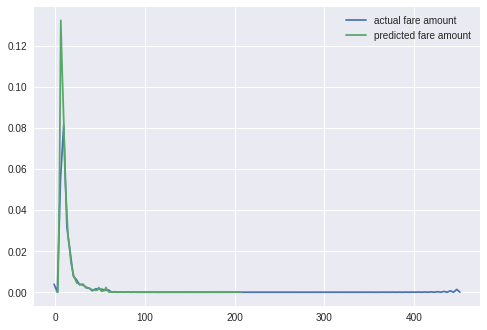

In [0]:
sns.kdeplot(y_test,label='actual fare amount')
sns.kdeplot(rf_pred,label='predicted fare amount')

LIGHT GBM Model

In [0]:
train_data=lgb.Dataset(X_train,label=y_train)

In [0]:
param = {'num_leaves':31, 'num_trees':5000, 'objective':'regression'}
param['metric'] = 'l2_root'

In [0]:
num_round=2500
cv_results = lgb.cv(param, train_data, num_boost_round=num_round, nfold=10,verbose_eval=20, early_stopping_rounds=20,stratified=False)

[20]	cv_agg's rmse: 5.13734 + 0.142921
[40]	cv_agg's rmse: 4.59973 + 0.159981
[60]	cv_agg's rmse: 4.40223 + 0.170886
[80]	cv_agg's rmse: 4.31836 + 0.17379
[100]	cv_agg's rmse: 4.25714 + 0.178198
[120]	cv_agg's rmse: 4.21185 + 0.17957
[140]	cv_agg's rmse: 4.18207 + 0.182133
[160]	cv_agg's rmse: 4.15853 + 0.180007
[180]	cv_agg's rmse: 4.14102 + 0.178886
[200]	cv_agg's rmse: 4.12597 + 0.183815
[220]	cv_agg's rmse: 4.11433 + 0.183702
[240]	cv_agg's rmse: 4.1028 + 0.183575
[260]	cv_agg's rmse: 4.09358 + 0.184713
[280]	cv_agg's rmse: 4.08549 + 0.185113
[300]	cv_agg's rmse: 4.08069 + 0.184614
[320]	cv_agg's rmse: 4.07431 + 0.184242
[340]	cv_agg's rmse: 4.06553 + 0.183583
[360]	cv_agg's rmse: 4.06043 + 0.184821
[380]	cv_agg's rmse: 4.05618 + 0.185081
[400]	cv_agg's rmse: 4.05125 + 0.185163
[420]	cv_agg's rmse: 4.04626 + 0.186777
[440]	cv_agg's rmse: 4.04242 + 0.18815
[460]	cv_agg's rmse: 4.0394 + 0.188403
[480]	cv_agg's rmse: 4.03713 + 0.187888
[500]	cv_agg's rmse: 4.03412 + 0.188114
[520]	cv_

In [0]:
print('Best num_boost_round:', len(cv_results['rmse-mean']))
#lgb_pred = lgb_bst.predict(X_test)

Best num_boost_round: 1034


In [0]:
lgb_bst=lgb.train(param,train_data,len(cv_results['rmse-mean']))
joblib.dump(lgb_bst, "gdrive/My Drive/lgbm_with_no_featureEngineering.sav")

['gdrive/My Drive/lgbm_with_no_featureEngineering.sav']

In [0]:
lgb_bst=joblib.load('gdrive/My Drive/lgbm_with_no_featureEngineering.sav')


lgb_pred = lgb_bst.predict(X_test)
lgb_rmse=np.sqrt(mean_squared_error(lgb_pred, y_test))
print("RMSE for Light GBM is ",lgb_rmse)

RMSE for Light GBM is  4.010645817660989


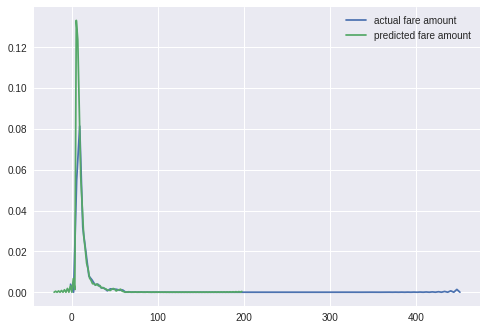

In [0]:
sns.kdeplot(y_test,label='actual fare amount')
sns.kdeplot(lgb_pred,label='predicted fare amount')